In [1]:
%pylab inline
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Runge function
def myfun(x):
    return 1/(1+50*(x-.5)**2)

In [4]:
N = 1025
M = 11

x = linspace(0,1, N)
q = linspace(0,1, M)
degree = 1

In [5]:
yq = myfun(q)

The combination of the functions `splrep` and `PPoly.from_spline` can be used to construct a piecewise polynomial objects, for which we can evaluate the value and all the derivatives at arbitrary points.

The basis functions are constructed from the spline interpolation by computing the piecewise interpolation of a function that has value one in one of the support points `q[i]` and zero in all other support points.

Such function is unique, there are `M` of them, and they define a basis for a piecewise polynomial space of dimension `M`.

We store in two matrices `B` and `dB` the values and the derivatives of all basis functions computed at the points `x`, for easy evaluation of integrals, and for easy plotting.

Moreover, we also store the piecewise polynomials themselves, to allow for their evaluation later on.

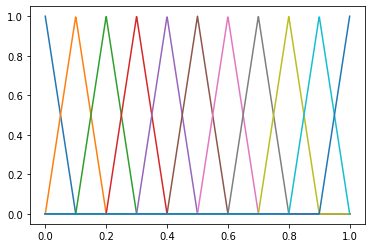

In [6]:
B = zeros((N,M))
dB = zeros((N,M))

basis = []
dbasis = []

for i in range(M):
    c = q*0
    c[i] = 1
    bi = PPoly.from_spline(splrep(q,c,k=degree))

    B[:,i] = bi(x)
    dB[:,i] = bi.derivative(1)(x)
    
    basis.append(bi)
    dbasis.append(bi.derivative(1))
_ = plot(x,B)

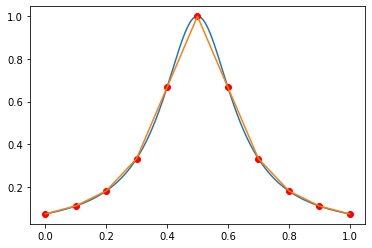

In [7]:
# This can be used to compute the piecewise polynomial interpolation of our function

plot(x, myfun(x))
plot(q, yq, 'ro')
plot(x, B.dot(myfun(q)))

In [8]:
# Now let's compute the least square approximation of `myfun` on all points `x`
# This is the same as computing the L2 projection when we approximate the integral by sum(1/N*f(x_i))

BtB = B.T.dot(B)
pL2 = linalg.solve(BtB, B.T.dot(myfun(x)))

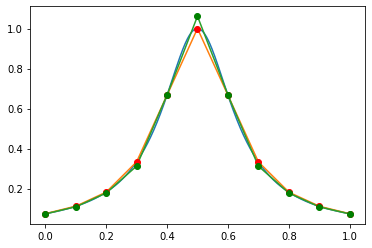

In [9]:
# Let's plot the approximated function, together with the interpolation

plot(x, myfun(x))
plot(x, B.dot(myfun(q)))
plot(x, B.dot(pL2))
plot(q, myfun(q), 'ro')
plot(q, pL2, 'go')

The finite element method is a similar way to approximate a variational formulation of a PDE problem.

Consider for example:

$$
-u'' +u = f
$$
with boundary conditions
$$
u'(0) = u'(1) = 0
$$

This can be written in variational form as
$$
(u', v') + (u,v) = (f,v) \qquad \forall v \in H^1([0,1])
$$
where $H^1([0,1])$ is the set of square integrable functions, with square integrable first derivative.

If we approximate the integrals by the sum of the values at the points `x`, then the above system can be solved in the finite dimensional space by

$$
(dB^T dB + B^T B) u = B^T f
$$
similarly to what we did before.

In [10]:
A = dB.T.dot(dB)+B.T.dot(B)

In [11]:
# the constant one: the solution is one.
rhs = B.T.dot(x*0+1)
u = linalg.solve(A, rhs)

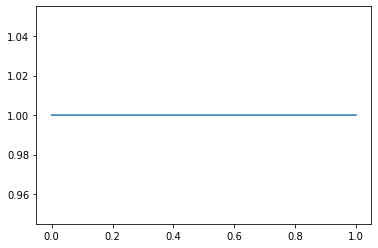

In [12]:
plot(x, B.dot(u))

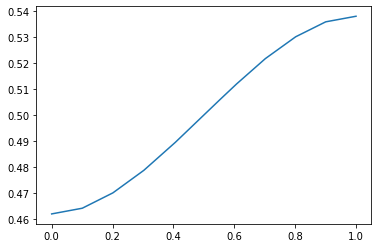

In [13]:
# Now test with f = x

rhs = B.T.dot(x)
u = linalg.solve(A, rhs)
_ = plot(x, B.dot(u))

In [14]:
# We expect the derivatives in 0 and 1 to be zero. There is an error here, that should decrease increasing M, 
# or integrating the matrices and the right hand side using Gauss quadrature rules (or both!).
dB.dot(u)[[0,-1]]

array([0.02156849, 0.02156901])

In order to compute the matrix and the right hand side using quadrature formulas, we use a collection of quadrature points and quadrature weights *on each interval* of the spline space. The intervals are stored as `x` (with some repeated entries) in the `PPoly` object.

In [15]:
# Make sure every interval border is taken only once
intervals = unique(basis[0].x)

# and make sure we can integrate exactly the product of two basis functions
qp, w = numpy.polynomial.legendre.leggauss(degree+1)

# Rescale the points and weights to work from zero to one
qp = (qp+1)/2
w /= 2

# Now replicate these points and weights in all the intervals
h = diff(intervals)
Q = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
W = array([w*h[i] for i in range(len(h))]).reshape((-1,))

In [16]:
# Check that we can integrate exactly x**(2*degree):
error = ((Q**(2*degree)).T.dot(W) - 1/(2*degree+1))
error

0.0

Now we compute the Basis functions and their derivatives on the quadrature points

In [17]:
Bq = array([basis[i](Q) for i in range(M)]).T
dBq = array([dbasis[i](Q) for i in range(M)]).T

To compute the L2 projection matrix $M_{ij} = (v_i, v_j)$ and the stiffness matrix $A_{ij} = (v_i', v_j')$, I will use `einsum`:

In [18]:
M = einsum('qi, q, qj', Bq, W, Bq)
K = einsum('qi, q, qj', dBq, W, dBq)

A = M+K

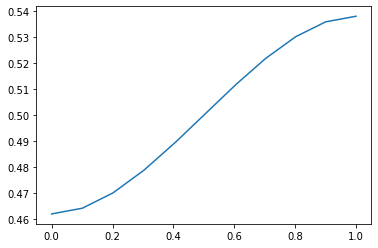

In [19]:
# Compute the same problem as before using the new way to compute integrals

rhs = einsum('qi, q, q', Bq, W, Q)
u = linalg.solve(A, rhs)

plot(x, B.dot(u))

In [20]:
# As we see, computing the integrals exactly does not change too much the result. You'll see that running 
# everything with higher M or higher degree makes the result a bit closer to what you should get theoretically
dB.dot(u)[[0,-1]]

array([0.02147356, 0.02147356])